In [1]:
# Load required libraries

# Load required libraries

import pandas as pd
import numpy as np
import sklearn as sk
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

import re
import random

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


from imblearn.under_sampling import RandomUnderSampler


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel, AdamW
from transformers import AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.nn import Dropout
from torch.nn import Linear
from tqdm import tqdm
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA
import torch.nn.functional as F
from transformers import DistilBertConfig
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold



from sklearn.metrics.pairwise import cosine_similarity

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import pandas as pd
df = pd.read_csv('/kaggle/input/sampled-1000/sampled_english_songs_10000.csv')

In [5]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel, AdamW
from transformers import AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
import torch

In [6]:
# Display the dimensions of the DataFrame
print(df.shape)

# Calculate the count of each value in the "Trainings-Labels" column
label_counts = df['tag'].value_counts()

# Print the label counts
print(label_counts)

(10000, 11)
tag
pop        4176
rap        2851
rock       1862
rb          447
misc        398
country     266
Name: count, dtype: int64


In [7]:
label_mapping = {'pop': 0, 'rap': 1, 'rock': 2, 'rb': 3, 'misc': 4, 'country': 5}

lyrics_list = df['lyrics'].tolist()
tag_list = df['tag'].tolist()

numeric_labels = torch.tensor([label_mapping[label] for label in tag_list])
numeric_labels

tensor([0, 4, 0,  ..., 2, 1, 0])

In [8]:
label_counts = pd.Series(numeric_labels).value_counts()
print(label_counts)

0    4176
1    2851
2    1862
3     447
4     398
5     266
Name: count, dtype: int64


In [9]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
class SongsDataset(Dataset):
    def __init__(self, songs, labels, tokenizer):
        self.songs = songs
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.songs)

    def __getitem__(self, idx):
        song = str(self.songs[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            song,
            truncation=True,
            padding='max_length',
            max_length=300,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [11]:
k = 5 # number of folds

skf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

# Lists for saving the training and test data
train_lyrics_list = []
test_lyrics_list = []
train_labels_list = []
test_labels_list = []

# K-Fold cross-validation for splitting the data
for train_index, test_index in skf.split(lyrics_list, numeric_labels):
    train_lyrics = [lyrics_list[i] for i in train_index]
    test_lyrics = [lyrics_list[i] for i in test_index]
    train_labels = [numeric_labels[i].item() for i in train_index]
    test_labels = [numeric_labels[i].item() for i in test_index]

    train_lyrics_list.append(train_lyrics)
    test_lyrics_list.append(test_lyrics)
    train_labels_list.append(train_labels)
    test_labels_list.append(test_labels)

In [12]:
# Create training and test records for each fold
train_datasets = []
test_datasets = []

for fold in range(k):
    train_dataset = SongsDataset(train_lyrics_list[fold], train_labels_list[fold], tokenizer)
    test_dataset = SongsDataset(test_lyrics_list[fold], test_labels_list[fold], tokenizer)

    train_datasets.append(train_dataset)
    test_datasets.append(test_dataset)

# Create training and test data loaders for each fold
train_dataloaders = []
test_dataloaders = []

for fold in range(k):
    train_dataloader = DataLoader(train_datasets[fold], batch_size=16, shuffle=True)
    test_dataloader = DataLoader(test_datasets[fold], batch_size=16, shuffle=False)

    train_dataloaders.append(train_dataloader)
    test_dataloaders.append(test_dataloader)

In [13]:
# Checking the number of records in the training and test datasets
for fold in range(k):
    print(f"Fold {fold+1}")
    train_dataset = train_datasets[fold]
    test_dataset = test_datasets[fold]

    print(f"Number of training data: {len(train_dataset)}")
    print(f"Number of testing data: {len(test_dataset)}")

# Verify the number of batches in the training and test data loaders.
for fold in range(k):
    print(f"Fold {fold+1}")
    train_dataloader = train_dataloaders[fold]
    test_dataloader = test_dataloaders[fold]

    print(f"Number of batches in the training dataloader: {len(train_dataloader)}")
    print(f"Number of batches in the testing dataloader: {len(test_dataloader)}")


Fold 1
Number of training data: 8000
Number of testing data: 2000
Fold 2
Number of training data: 8000
Number of testing data: 2000
Fold 3
Number of training data: 8000
Number of testing data: 2000
Fold 4
Number of training data: 8000
Number of testing data: 2000
Fold 5
Number of training data: 8000
Number of testing data: 2000
Fold 1
Number of batches in the training dataloader: 500
Number of batches in the testing dataloader: 125
Fold 2
Number of batches in the training dataloader: 500
Number of batches in the testing dataloader: 125
Fold 3
Number of batches in the training dataloader: 500
Number of batches in the testing dataloader: 125
Fold 4
Number of batches in the training dataloader: 500
Number of batches in the testing dataloader: 125
Fold 5
Number of batches in the training dataloader: 500
Number of batches in the testing dataloader: 125


In [14]:
# Convert train_labels to a numpy array
train_labels_array = np.array(train_labels)

# Count the number of data series per numeric_label
unique_labels, label_counts = np.unique(train_labels_array, return_counts=True)

# Create a dictionary to represent the number of data series per numeric_label
label_counts_dict = dict(zip(unique_labels, label_counts))

# Output the number of data series per numeric_label
for label, count in label_counts_dict.items():
    print(f"Numeric_Label {label}: {count} Data series")


Numeric_Label 0: 3341 Data series
Numeric_Label 1: 2281 Data series
Numeric_Label 2: 1489 Data series
Numeric_Label 3: 358 Data series
Numeric_Label 4: 319 Data series
Numeric_Label 5: 212 Data series


In [15]:
# Convert test_labels to a numpy array
test_labels_array = np.array(test_labels)

# Count the number of data series per numeric_label
unique_labels, label_counts = np.unique(test_labels_array, return_counts=True)

# Create a dictionary to represent the number of data series per numeric_label
label_counts_dict = dict(zip(unique_labels, label_counts))

# Output the number of data series per numeric_label
for label, count in label_counts_dict.items():
    print(f"Numeric_Label {label}: {count} Data series")

Numeric_Label 0: 835 Data series
Numeric_Label 1: 570 Data series
Numeric_Label 2: 373 Data series
Numeric_Label 3: 89 Data series
Numeric_Label 4: 79 Data series
Numeric_Label 5: 54 Data series


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 5
learning_rate = 1e-4
warmup_steps = 100

In [17]:
# Training for each fold
for fold in range(k):
    print(f"Fold {fold+1}/{k}")

    train_dataloader = train_dataloaders[fold]

    model.to(device)
    model.train()

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        total_train_loss = 0

        for batch in tqdm(train_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = nn.CrossEntropyLoss()(logits, labels)
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f"Train Loss: {avg_train_loss}")

Fold 1/5


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5


100%|██████████| 500/500 [03:29<00:00,  2.39it/s]


Train Loss: 1.033306248486042
Epoch 2/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Train Loss: 0.8037058811187744
Epoch 3/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Train Loss: 0.5741122993677854
Epoch 4/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Train Loss: 0.31424113412201404
Epoch 5/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Train Loss: 0.1544094025203958
Fold 2/5
Epoch 1/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Train Loss: 0.5178578829094768
Epoch 2/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Train Loss: 0.3416111866161227
Epoch 3/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Train Loss: 0.19150361708179117
Epoch 4/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Train Loss: 0.09786803083051927
Epoch 5/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Train Loss: 0.04506708221917506
Fold 3/5
Epoch 1/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Train Loss: 0.2543219996991102
Epoch 2/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Train Loss: 0.2026606219909154
Epoch 3/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Train Loss: 0.11178715678502339
Epoch 4/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Train Loss: 0.04970966756780399
Epoch 5/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Train Loss: 0.02212128786399262
Fold 4/5
Epoch 1/5


100%|██████████| 500/500 [03:27<00:00,  2.41it/s]


Train Loss: 0.1726815042462258
Epoch 2/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Train Loss: 0.13139804494020063
Epoch 3/5


100%|██████████| 500/500 [03:27<00:00,  2.41it/s]


Train Loss: 0.05663677484318032
Epoch 4/5


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Train Loss: 0.028128403620095922
Epoch 5/5


100%|██████████| 500/500 [03:27<00:00,  2.41it/s]


Train Loss: 0.009444781661077286
Fold 5/5
Epoch 1/5


100%|██████████| 500/500 [03:27<00:00,  2.41it/s]


Train Loss: 0.12746170782274566
Epoch 2/5


100%|██████████| 500/500 [03:27<00:00,  2.41it/s]


Train Loss: 0.09642589196335757
Epoch 3/5


100%|██████████| 500/500 [03:27<00:00,  2.41it/s]


Train Loss: 0.04672792607177689
Epoch 4/5


100%|██████████| 500/500 [03:27<00:00,  2.41it/s]


Train Loss: 0.026897272990056082
Epoch 5/5


100%|██████████| 500/500 [03:27<00:00,  2.41it/s]

Train Loss: 0.008489729977307434


In [18]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Evaluation for each fold
for fold in range(k):
    print(f"Evaluation for Fold {fold+1}/{k}")

    test_dataloader = test_dataloaders[fold]

    model.eval()
    total_eval_loss = 0
    predictions = []
    true_labels = []

    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        loss = nn.CrossEntropyLoss()(logits, labels)
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)

    avg_eval_loss = total_eval_loss / len(test_dataloader)
    print(f"Evaluation Loss: {avg_eval_loss}")

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")

Evaluation for Fold 1/5


100%|██████████| 125/125 [00:31<00:00,  3.94it/s]


Evaluation Loss: 8.654577017296106e-05
Accuracy: 1.0
F1 Score: 1.0
Evaluation for Fold 2/5


100%|██████████| 125/125 [00:31<00:00,  3.93it/s]


Evaluation Loss: 0.003715997420833446
Accuracy: 0.9995
F1 Score: 0.9994977686586304
Evaluation for Fold 3/5


100%|██████████| 125/125 [00:31<00:00,  3.92it/s]


Evaluation Loss: 0.0018852117890492083
Accuracy: 0.9995
F1 Score: 0.9995021866583046
Evaluation for Fold 4/5


100%|██████████| 125/125 [00:31<00:00,  3.99it/s]


Evaluation Loss: 7.10417874797713e-05
Accuracy: 1.0
F1 Score: 1.0
Evaluation for Fold 5/5


100%|██████████| 125/125 [00:30<00:00,  4.06it/s]

Evaluation Loss: 0.02516421916836407
Accuracy: 0.995
F1 Score: 0.995003261925716


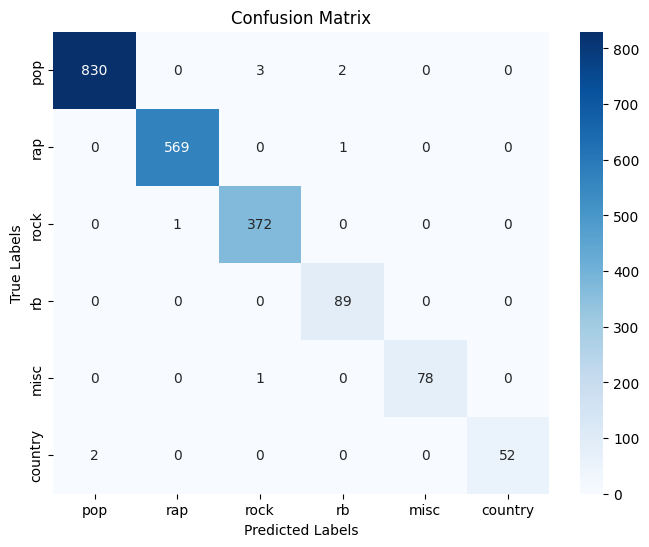

In [19]:
# Calculate the Confusion Matrix
confusion_mat = confusion_matrix(true_labels, predictions, labels=np.unique(true_labels))

# Labels for the axes labels
label_names = list(label_mapping.keys())

# Convert the Confusion Matrix to a Pandas DataFrame
cm_df = pd.DataFrame(confusion_mat, index=label_names, columns=label_names)

# Plot of the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [20]:
torch.save(model, 'llm_model.pth')

In [ ]:
index_to_label = {index: label for label, index in label_mapping.items()}

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

def prepare_text_for_prediction(text, tokenizer, max_length=512):
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    return encoded_text

def predict_text(text, tokenizer, model, device,index_to_label):
    # Prepare the text for prediction
    inputs = prepare_text_for_prediction(text, tokenizer)

    # Move the inputs to the correct device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Predict using the model
    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        softmax_scores = torch.nn.functional.softmax(logits, dim=1)
        predicted_class_idx = torch.argmax(softmax_scores, dim=1).item()
        predicted_label = index_to_label[predicted_class_idx]
        probabilities = softmax_scores[0].tolist()

    return predicted_label, probabilities

text = "In the heart of the country, under a wide blue sky,Where the fields stretch out like a sweet lullaby.There's a story of love that never grows old,Of a cowboy's heart, brave and bold.Chorus:Whispers on the wind, calling me home,To the place where the wildflowers roam.In your arms, I find my peace,In the country's heart, my soul's release.Verse 2:Under the stars, by the light of the moon,We dance to the tune of an old country tune.With your hand in mine, troubles fade away,In each other's eyes, we find our way.Chorus:Whispers on the wind, calling me home,To the place where the rivers gently roam.In your arms, I find my peace,In the country's heart, love's sweet release.Bridge:Through the storms, through the pain,Our love's like a gentle rain.Washing away all the sorrow,Leading us to a bright tomorrow.Verse 3:As the sun sets, painting the sky,I thank the stars for you and I.In this simple life, we've found our dream,In the country's heart, we're a perfect team.Chorus:Whispers on the wind, calling me home,To the place where the old oaks stand strong.In your arms, I find my peace,In the country's heart, our love's sweet lease.Outro:So here we stand, in love's sweet embrace,In the country's heart, we've found our place.With whispers on the wind, and love so true,In the heart of the country, I found you."
predicted_label, probabilities = predict_text(text, tokenizer, model, device, index_to_label)
print(f"Predicted class: {predicted_label}, Predicted probabilities: {probabilities}")